In [19]:
# Need the older version of pandas for pickling the xarray to work. 
# !pip install "pandas<2.0.0"
import pickle
import numpy as np
import pandas as pd
import os
import cv2
import json
import matplotlib.pyplot as plt
import xarray as xr
import tifffile
from PIL import Image
from dea_tools.plotting import display_map, rgb, xr_animation
from datetime import datetime

In [20]:
def create_lat_lon(bbox, shape):
    """ Create the latitudes and longitudes

    Parameters
    ----------
    bbox: list of float
    shape: list of int
    
    Returns
    -------
    x: 1d-array
    y: 1d-array
    """
    pixel_size = (bbox[2] - bbox[0])/shape[0], (bbox[3] - bbox[1])/shape[1]
    y = np.arange(bbox[0], bbox[2], pixel_size[0])
    x = np.arange(bbox[1], bbox[3], pixel_size[1])
    return x, y

In [21]:
def merge_datasets(ds_, ds2, crs='EPSG:32755'):
    """ 
    Combines two xarrays
    Assumes bands are named (nbart_red, nbart_green, nbart_blue, nbart_nir_1), each with dimensions (time, y, x)
    Sorts by timestamp for compatibility with dea_tools.plotting.xr_animation
    Drops the extra 4 bands from the planetscope data ("Coastal Blue", "Green I", "Yellow", "Red Edge")

    Parameters
    ----------
    ds1: xarray.Dataset
    ds2: xarray.Dataset

    Returns
    ----------
    ds_merged: xarray.Dataset
    """
    ds1_bands = list(zip(ds1["time"], ds1["nbart_red"], ds1["nbart_green"], ds1["nbart_blue"], ds1["nbart_nir_1"]))
    ds2_bands = list(zip(ds2["time"], ds2["nbart_red"], ds2["nbart_green"], ds2["nbart_blue"], ds2["nbart_nir_1"]))
    ds_merged_bands = sorted(ds1_bands + ds2_bands)
    time_merged = [t[0].values for t in ds_merged_bands]
    red_merged = [t[1] for t in ds_merged_bands]
    green_merged = [t[2] for t in ds_merged_bands]
    blue_merged = [t[3] for t in ds_merged_bands]
    nir_merged = [t[4] for t in ds_merged_bands]
    x = ds1.x.values
    y = ds1.y.values
    ds_merged = xr.Dataset(
        {
            "nbart_red":(["time",  "y", "x"], red_merged),
            "nbart_green":(["time",  "y", "x"], green_merged),
            "nbart_blue":(["time",  "y", "x"], blue_merged),
            "nbart_nir_1":(["time",  "y", "x"], nir_merged)
        },
        coords={
            "time": time_merged,
            "y": ("y", y),
            "x": ("x", x),
        },
    )
    ds_merged = ds_merged.odc.assign_crs(crs=crs)
    return ds_merged

In [22]:
filename_sentinel_2019 = 'sentinel_arbo_4bands_2019-2024.pickle'
filename_planetscope_2020 = 'planetscope_arbo_8bands_2020-2021.pickle'
# filename_planetscope_2021 = 'planetscope_arbo_8bands_2021-2024.pickle'

In [23]:
with open(filename_sentinel_2019, 'rb') as handle:
    ds_sentinel_2019 = pickle.load(handle)
ds_sentinel_2019

<xarray.Dataset> Size: 999MB
Dimensions:      (time: 144, y: 660, x: 657)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2019-01-15T00:06:27.817000 ... 202...
  * y            (y) float64 5kB 6.096e+06 6.096e+06 ... 6.09e+06 6.09e+06
  * x            (x) float64 5kB 6.857e+05 6.857e+05 ... 6.922e+05 6.922e+05
    spatial_ref  int32 4B 32755
Data variables:
    nbart_red    (time, y, x) float32 250MB 706.0 630.0 ... 1.29e+03 2.064e+03
    nbart_green  (time, y, x) float32 250MB 635.0 560.0 ... 1.115e+03 1.764e+03
    nbart_blue   (time, y, x) float32 250MB 416.0 380.0 ... 825.0 1.435e+03
    nbart_nir_1  (time, y, x) float32 250MB 2.197e+03 2.274e+03 ... 2.533e+03
Attributes:
    crs:           epsg:32755
    grid_mapping:  spatial_ref

In [24]:
with open(filename_planetscope_2020, 'rb') as handle:
    ds_planetscope_2020 = pickle.load(handle)
ds_planetscope_2020

<xarray.Dataset> Size: 3GB
Dimensions:       (time: 98, y: 660, x: 657)
Coordinates:
  * time          (time) datetime64[ns] 784B 2020-03-19T23:15:57 ... 2021-08-...
  * y             (y) float64 5kB 6.856e+05 6.856e+05 ... 6.922e+05 6.922e+05
  * x             (x) float64 5kB 6.09e+06 6.09e+06 ... 6.096e+06 6.096e+06
    spatial_ref   int32 4B 32755
Data variables:
    Coastal Blue  (time, y, x) float64 340MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nbart_blue    (time, y, x) float64 340MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Green I       (time, y, x) float64 340MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nbart_green   (time, y, x) float64 340MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Yellow        (time, y, x) float64 340MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nbart_red     (time, y, x) float64 340MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Red Edge      (time, y, x) float64 340MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nbart_nir_1   (time, y, x) float64 340MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [25]:
ds1 = ds_sentinel_2019

In [26]:
ds2 = merge_datasets(ds1, ds_planetscope_2020)

In [27]:
ds2

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 242, y: 660, x: 657)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2019-01-15T00:06:27.817000 ... 202...
  * y            (y) float64 5kB 6.096e+06 6.096e+06 ... 6.09e+06 6.09e+06
  * x            (x) float64 5kB 6.857e+05 6.857e+05 ... 6.922e+05 6.922e+05
    spatial_ref  int32 4B 32755
Data variables:
    nbart_red    (time, y, x) float64 839MB 706.0 630.0 ... 1.29e+03 2.064e+03
    nbart_green  (time, y, x) float64 839MB 635.0 560.0 ... 1.115e+03 1.764e+03
    nbart_blue   (time, y, x) float64 839MB 416.0 380.0 ... 825.0 1.435e+03
    nbart_nir_1  (time, y, x) float64 839MB 2.197e+03 2.274e+03 ... 2.533e+03

/Users/christopherbradley/miniconda3/envs/cubeenv/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


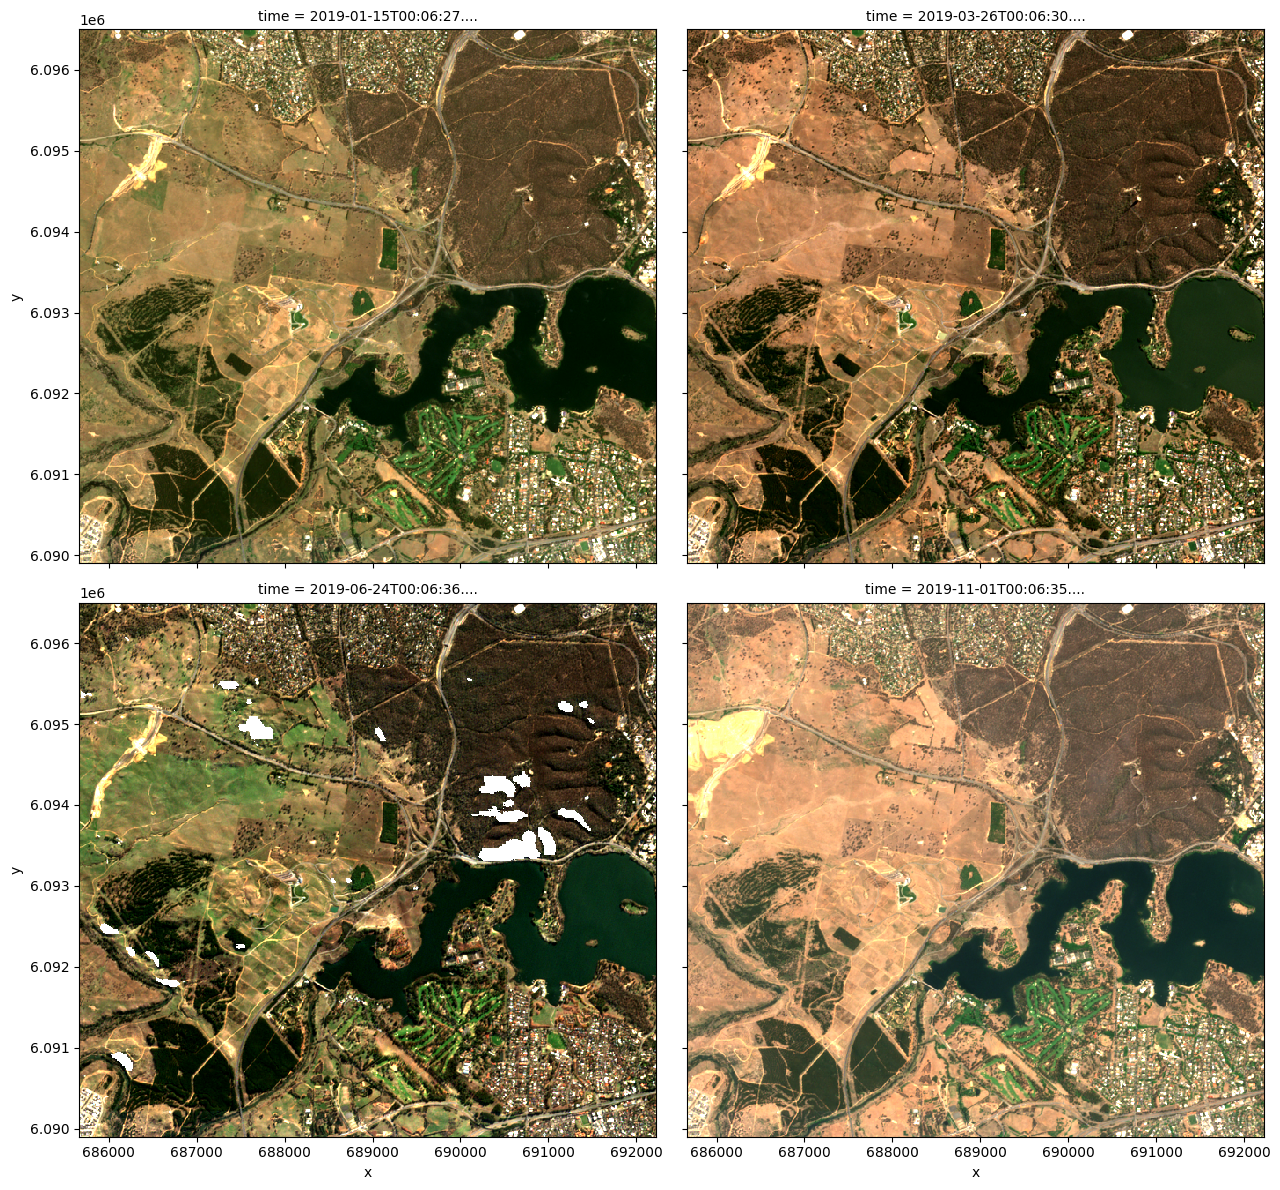

In [28]:
rgb(ds2, index=[0,10,20,30], col_wrap=2)

Exporting animation to animation.mp4


  0%|          | 0/242 (0.0 seconds remaining at ? frames/s)

/Users/christopherbradley/miniconda3/envs/cubeenv/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


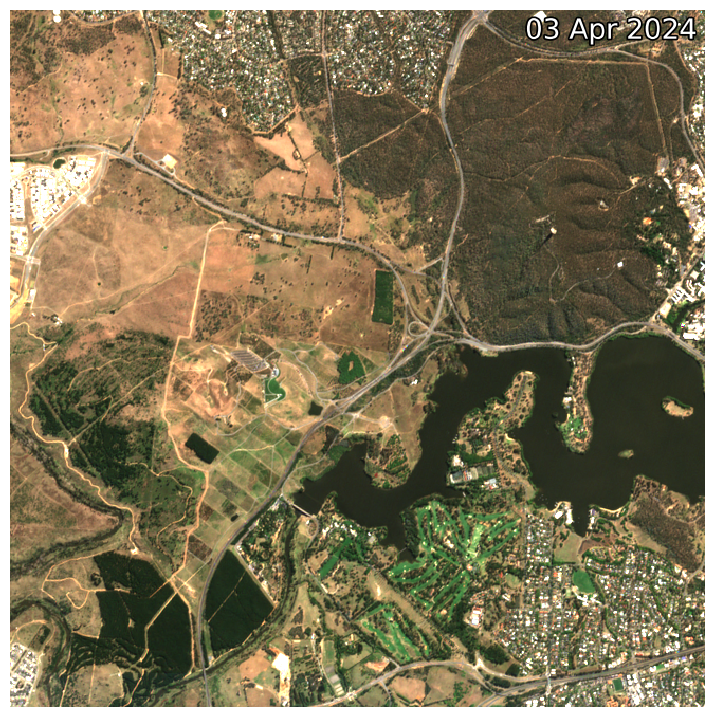

In [29]:
xr_animation(ds2, bands=['nbart_red', 'nbart_green', 'nbart_blue'])